<a href="https://colab.research.google.com/github/aimbsg/EVA4_S9/blob/master/EVA4_S9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assignment:

Move your last code's transformations to Albumentations. 

Apply ToTensor, HorizontalFlip, Normalize (at min) + More (for additional points)

Please make sure that your test_transforms are simple and only using ToTensor and Normalize

Implement GradCam function as a module. 

Your final code (notebook file) must use imported functions to implement transformations and GradCam functionality

Target Accuracy is 87%

In [0]:
!pip install -U git+https://github.com/albu/albumentations

In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sys
my_path = '/content/gdrive/My Drive/EVA4S9_CIFAR10'
sys.path.append(my_path)

In [0]:
%matplotlib inline
import torch
import data_loader as train_test_loader
import visualize_images as show_images
import backbone as model
import train_test
import model_evaluator as evaluate
from transforms_albumentation import AlbumentationTransforms
from gradcam import GradCAM,visualize_cam

In [0]:
import albumentations as A

channel_means = (0.5, 0.5, 0.5)
channel_stdevs = (0.5, 0.5, 0.5)
train_transform = AlbumentationTransforms([
                                       A.Rotate((-30.0, 30.0)),
                                       A.HorizontalFlip(),
                                       A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                       A.Normalize(mean=channel_means, std=channel_stdevs),
                                       A.Cutout(num_holes=1, max_h_size=16,max_w_size = 16,p=1) 
                                       ])
# Test Phase transformations
test_transform = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])

In [5]:
classes, trainloader, testloader = train_test_loader.load(train_transform,test_transform)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
CUDA Available? True


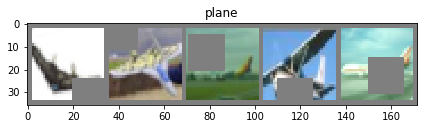

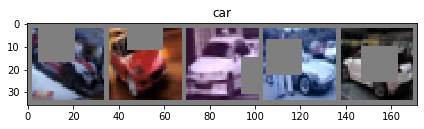

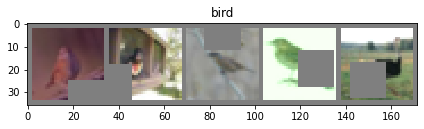

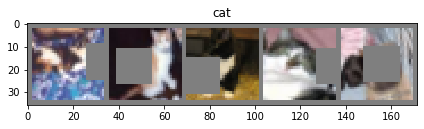

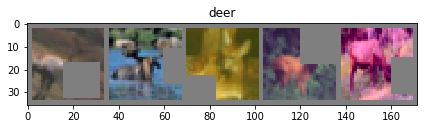

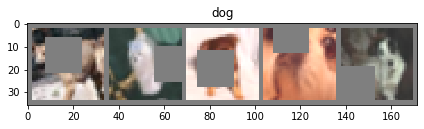

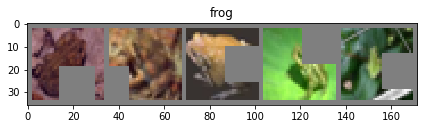

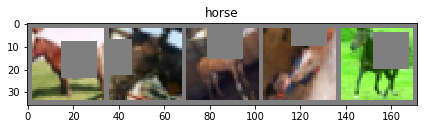

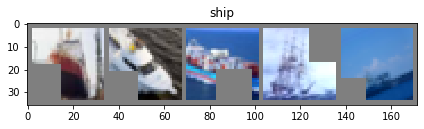

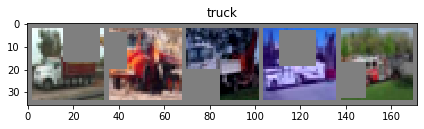

In [0]:
show_images.show_train_data(trainloader, classes)

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = model.ResNet18(dropout=0.1).to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR , MultiStepLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9,weight_decay=0.0005)
scheduler = StepLR(optimizer, step_size=12, gamma=0.1)

In [0]:
test_loss = []
test_acc = []
EPOCHS = 50
for epoch in range(EPOCHS):
     print("EPOCH:", epoch+1,'LR:',optimizer.param_groups[0]['lr'])
     train_test.train(model, device, trainloader, optimizer, criterion, epoch)
     scheduler.step()
     test_loss , test_acc = train_test.test(model, device, criterion, testloader)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.1


Loss=2.0033950805664062 Batch_id=390 Accuracy=20.45: 100%|██████████| 391/391 [01:06<00:00,  5.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0141, Accuracy: 3380/10000 (33.80%)

EPOCH: 2 LR: 0.1


Loss=1.9688482284545898 Batch_id=390 Accuracy=34.08: 100%|██████████| 391/391 [01:10<00:00,  5.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0122, Accuracy: 4298/10000 (42.98%)

EPOCH: 3 LR: 0.1


Loss=1.4445469379425049 Batch_id=390 Accuracy=42.23: 100%|██████████| 391/391 [01:10<00:00,  5.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0111, Accuracy: 4902/10000 (49.02%)

EPOCH: 4 LR: 0.1


Loss=1.3163485527038574 Batch_id=390 Accuracy=50.16: 100%|██████████| 391/391 [01:11<00:00,  5.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0106, Accuracy: 5473/10000 (54.73%)

EPOCH: 5 LR: 0.1


Loss=1.0407934188842773 Batch_id=390 Accuracy=55.86: 100%|██████████| 391/391 [01:11<00:00,  5.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Accuracy: 6402/10000 (64.02%)

EPOCH: 6 LR: 0.1


Loss=1.0835762023925781 Batch_id=390 Accuracy=60.18: 100%|██████████| 391/391 [01:11<00:00,  5.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0079, Accuracy: 6577/10000 (65.77%)

EPOCH: 7 LR: 0.1


Loss=1.0747668743133545 Batch_id=390 Accuracy=63.26: 100%|██████████| 391/391 [01:11<00:00,  5.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0069, Accuracy: 6989/10000 (69.89%)

EPOCH: 8 LR: 0.1


Loss=1.1485226154327393 Batch_id=390 Accuracy=65.23: 100%|██████████| 391/391 [01:11<00:00,  5.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0069, Accuracy: 6896/10000 (68.96%)

EPOCH: 9 LR: 0.1


Loss=0.8814910650253296 Batch_id=390 Accuracy=66.46: 100%|██████████| 391/391 [01:11<00:00,  5.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0075, Accuracy: 6739/10000 (67.39%)

EPOCH: 10 LR: 0.1


Loss=0.9608715772628784 Batch_id=390 Accuracy=67.62: 100%|██████████| 391/391 [01:11<00:00,  5.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0076, Accuracy: 6859/10000 (68.59%)

EPOCH: 11 LR: 0.1


Loss=0.8257074356079102 Batch_id=390 Accuracy=68.09: 100%|██████████| 391/391 [01:10<00:00,  5.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 7407/10000 (74.07%)

EPOCH: 12 LR: 0.1


Loss=0.7791465520858765 Batch_id=390 Accuracy=69.61: 100%|██████████| 391/391 [01:10<00:00,  5.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 7236/10000 (72.36%)

EPOCH: 13 LR: 0.010000000000000002


Loss=0.7809880375862122 Batch_id=390 Accuracy=75.34: 100%|██████████| 391/391 [01:10<00:00,  5.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8314/10000 (83.14%)

EPOCH: 14 LR: 0.010000000000000002


Loss=0.6961116194725037 Batch_id=390 Accuracy=77.81: 100%|██████████| 391/391 [01:10<00:00,  5.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8360/10000 (83.60%)

EPOCH: 15 LR: 0.010000000000000002


Loss=0.4522596299648285 Batch_id=390 Accuracy=78.36: 100%|██████████| 391/391 [01:10<00:00,  5.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8430/10000 (84.30%)

EPOCH: 16 LR: 0.010000000000000002


Loss=0.490490585565567 Batch_id=390 Accuracy=79.04: 100%|██████████| 391/391 [01:10<00:00,  5.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8473/10000 (84.73%)

EPOCH: 17 LR: 0.010000000000000002


Loss=0.49033862352371216 Batch_id=390 Accuracy=79.83: 100%|██████████| 391/391 [01:10<00:00,  5.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8527/10000 (85.27%)

EPOCH: 18 LR: 0.010000000000000002


Loss=0.5617526173591614 Batch_id=390 Accuracy=80.52: 100%|██████████| 391/391 [01:10<00:00,  5.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8544/10000 (85.44%)

EPOCH: 19 LR: 0.010000000000000002


Loss=0.5222152471542358 Batch_id=390 Accuracy=80.39: 100%|██████████| 391/391 [01:10<00:00,  5.57it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8534/10000 (85.34%)

EPOCH: 20 LR: 0.010000000000000002


Loss=0.46095871925354004 Batch_id=390 Accuracy=80.92: 100%|██████████| 391/391 [01:10<00:00,  5.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8529/10000 (85.29%)

EPOCH: 21 LR: 0.010000000000000002


Loss=0.4823540151119232 Batch_id=390 Accuracy=81.42: 100%|██████████| 391/391 [01:10<00:00,  5.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8568/10000 (85.68%)

EPOCH: 22 LR: 0.010000000000000002


Loss=0.4944075047969818 Batch_id=390 Accuracy=81.61: 100%|██████████| 391/391 [01:10<00:00,  5.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8601/10000 (86.01%)

EPOCH: 23 LR: 0.010000000000000002


Loss=0.5115967392921448 Batch_id=390 Accuracy=82.18: 100%|██████████| 391/391 [01:10<00:00,  5.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8620/10000 (86.20%)

EPOCH: 24 LR: 0.010000000000000002


Loss=0.4597623944282532 Batch_id=390 Accuracy=82.47: 100%|██████████| 391/391 [01:10<00:00,  5.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8658/10000 (86.58%)

EPOCH: 25 LR: 0.0010000000000000002


Loss=0.5610634088516235 Batch_id=390 Accuracy=83.87: 100%|██████████| 391/391 [01:10<00:00,  5.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8802/10000 (88.02%)

EPOCH: 26 LR: 0.0010000000000000002


Loss=0.40024346113204956 Batch_id=390 Accuracy=84.52: 100%|██████████| 391/391 [01:10<00:00,  5.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8795/10000 (87.95%)

EPOCH: 27 LR: 0.0010000000000000002


Loss=0.5071297883987427 Batch_id=390 Accuracy=84.70: 100%|██████████| 391/391 [01:10<00:00,  5.57it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8851/10000 (88.51%)

EPOCH: 28 LR: 0.0010000000000000002


Loss=0.3418145477771759 Batch_id=390 Accuracy=84.73: 100%|██████████| 391/391 [01:10<00:00,  5.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8785/10000 (87.85%)

EPOCH: 29 LR: 0.0010000000000000002


Loss=0.42223256826400757 Batch_id=390 Accuracy=84.90: 100%|██████████| 391/391 [01:10<00:00,  5.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8863/10000 (88.63%)

EPOCH: 30 LR: 0.0010000000000000002


Loss=0.5179008841514587 Batch_id=390 Accuracy=85.12: 100%|██████████| 391/391 [01:10<00:00,  5.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8837/10000 (88.37%)

EPOCH: 31 LR: 0.0010000000000000002


Loss=0.4204595983028412 Batch_id=390 Accuracy=85.17: 100%|██████████| 391/391 [01:10<00:00,  5.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8830/10000 (88.30%)

EPOCH: 32 LR: 0.0010000000000000002


Loss=0.41509953141212463 Batch_id=390 Accuracy=85.15: 100%|██████████| 391/391 [01:10<00:00,  5.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8861/10000 (88.61%)

EPOCH: 33 LR: 0.0010000000000000002


Loss=0.39737266302108765 Batch_id=390 Accuracy=85.42: 100%|██████████| 391/391 [01:10<00:00,  5.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8875/10000 (88.75%)

EPOCH: 34 LR: 0.0010000000000000002


Loss=0.42042893171310425 Batch_id=390 Accuracy=85.60: 100%|██████████| 391/391 [01:10<00:00,  5.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8872/10000 (88.72%)

EPOCH: 35 LR: 0.0010000000000000002


Loss=0.4804908335208893 Batch_id=390 Accuracy=85.75: 100%|██████████| 391/391 [01:10<00:00,  5.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8858/10000 (88.58%)

EPOCH: 36 LR: 0.0010000000000000002


Loss=0.4138643741607666 Batch_id=390 Accuracy=85.79: 100%|██████████| 391/391 [01:10<00:00,  5.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8873/10000 (88.73%)

EPOCH: 37 LR: 0.00010000000000000003


Loss=0.3905956745147705 Batch_id=390 Accuracy=85.97: 100%|██████████| 391/391 [01:10<00:00,  5.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8848/10000 (88.48%)

EPOCH: 38 LR: 0.00010000000000000003


Loss=0.7334610223770142 Batch_id=390 Accuracy=86.06: 100%|██████████| 391/391 [01:10<00:00,  5.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8864/10000 (88.64%)

EPOCH: 39 LR: 0.00010000000000000003


Loss=0.27063116431236267 Batch_id=390 Accuracy=86.21: 100%|██████████| 391/391 [01:10<00:00,  5.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8872/10000 (88.72%)

EPOCH: 40 LR: 0.00010000000000000003


Loss=0.33159440755844116 Batch_id=390 Accuracy=85.96: 100%|██████████| 391/391 [01:10<00:00,  5.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8871/10000 (88.71%)

EPOCH: 41 LR: 0.00010000000000000003


Loss=0.5462621450424194 Batch_id=390 Accuracy=86.18: 100%|██████████| 391/391 [01:10<00:00,  5.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8892/10000 (88.92%)

EPOCH: 42 LR: 0.00010000000000000003


Loss=0.320993036031723 Batch_id=390 Accuracy=86.31: 100%|██████████| 391/391 [01:10<00:00,  5.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 8875/10000 (88.75%)

EPOCH: 43 LR: 0.00010000000000000003


Loss=0.36389830708503723 Batch_id=390 Accuracy=86.14: 100%|██████████| 391/391 [01:10<00:00,  5.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8861/10000 (88.61%)

EPOCH: 44 LR: 0.00010000000000000003


Loss=0.6768866777420044 Batch_id=390 Accuracy=86.13: 100%|██████████| 391/391 [01:10<00:00,  5.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 8910/10000 (89.10%)

EPOCH: 45 LR: 0.00010000000000000003


Loss=0.4458858072757721 Batch_id=390 Accuracy=86.20: 100%|██████████| 391/391 [01:10<00:00,  5.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8866/10000 (88.66%)

EPOCH: 46 LR: 0.00010000000000000003


Loss=0.4890214800834656 Batch_id=390 Accuracy=86.32: 100%|██████████| 391/391 [01:10<00:00,  5.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 8887/10000 (88.87%)

EPOCH: 47 LR: 0.00010000000000000003


Loss=0.4521031379699707 Batch_id=390 Accuracy=86.01: 100%|██████████| 391/391 [01:10<00:00,  5.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 8884/10000 (88.84%)

EPOCH: 48 LR: 0.00010000000000000003


Loss=0.5393925309181213 Batch_id=390 Accuracy=86.02: 100%|██████████| 391/391 [01:10<00:00,  5.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 8917/10000 (89.17%)

EPOCH: 49 LR: 1.0000000000000004e-05


Loss=0.4289189279079437 Batch_id=390 Accuracy=86.34: 100%|██████████| 391/391 [01:10<00:00,  5.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8857/10000 (88.57%)

EPOCH: 50 LR: 1.0000000000000004e-05


Loss=0.41719508171081543 Batch_id=390 Accuracy=86.34: 100%|██████████| 391/391 [01:10<00:00,  5.53it/s]



Test set: Average loss: 0.0026, Accuracy: 8895/10000 (88.95%)



Validation Accuracy :

In [0]:
evaluate.val_accuracy(model, device, testloader)

Accuracy of the network on the 10000 test images: 88 %


In [0]:
evaluate.class_accuracy(model, device, classes, testloader)

Accuracy of plane : 88 %
Accuracy of   car : 97 %
Accuracy of  bird : 86 %
Accuracy of   cat : 77 %
Accuracy of  deer : 88 %
Accuracy of   dog : 81 %
Accuracy of  frog : 92 %
Accuracy of horse : 92 %
Accuracy of  ship : 94 %
Accuracy of truck : 92 %


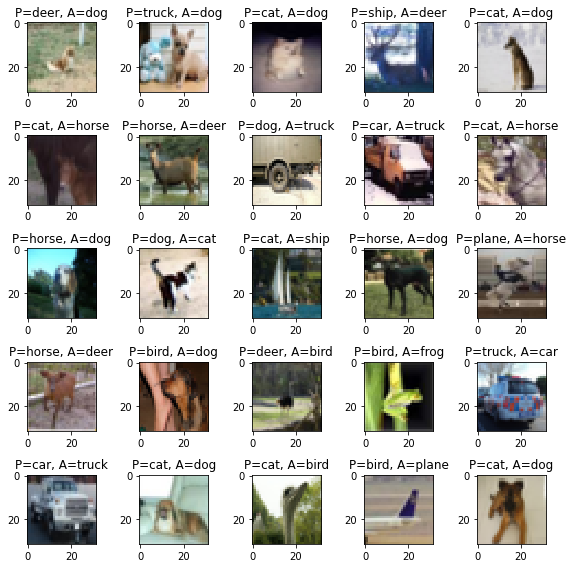

In [0]:
evaluate.view_misclassified_images(model, device, testloader, classes)

Text(0.5, 1.0, 'Test Accuracy')

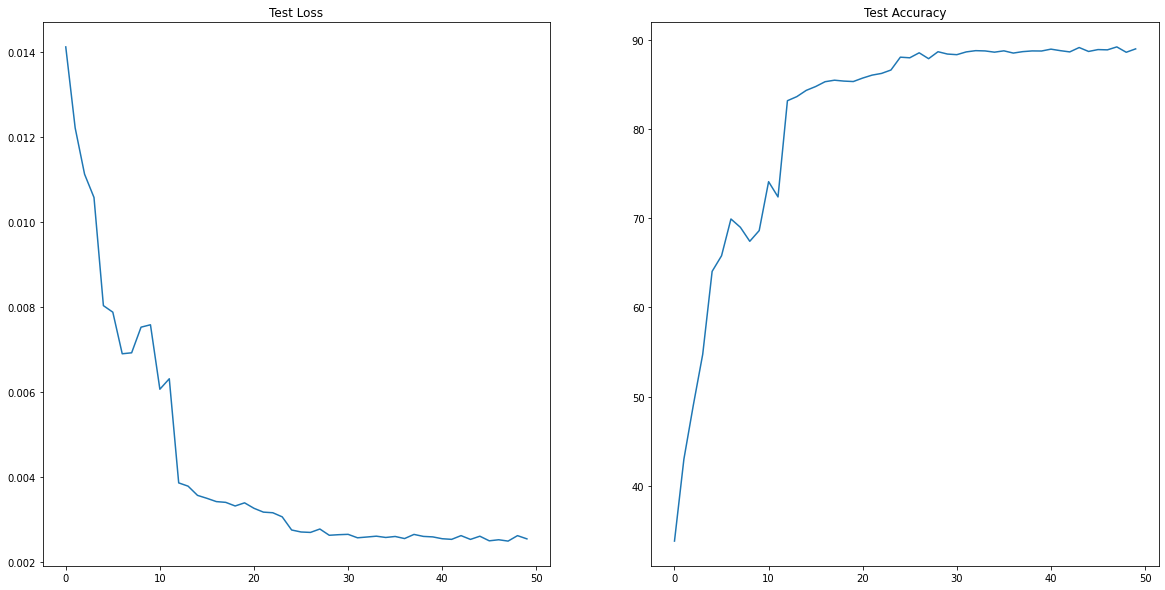

In [0]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2, figsize=(20,10))

axs[0].plot(test_loss)
axs[0].set_title("Test Loss")

axs[1].plot(test_acc)
axs[1].set_title("Test Accuracy")

In [8]:
%cd '/content/gdrive/My Drive/EVA4S9_CIFAR10/'
!pwd

/content/gdrive/My Drive/EVA4S9_CIFAR10
/content/gdrive/My Drive/EVA4S9_CIFAR10


In [0]:
checkpoint_path_50 = "/content/gdrive/My Drive/EVA4S9_CIFAR10/eva4s9_model_save_50.pth"

In [0]:
valid_loss = 0.41719508171081543 #Manually saving the last loss
checkpoint_50 = {
            'epoch': epoch + 1,
            'valid_loss_min': valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }      

In [0]:
def save_ckp(state, checkpoint_path):
    """
    state: checkpoint we want to save
    checkpoint_path: path to save checkpoint
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)

In [0]:
# save checkpoint
save_ckp(checkpoint_50, checkpoint_path_50)

In [0]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min

In [0]:
model, optimizer, start_epoch, valid_loss = load_ckp(checkpoint_path_50, model, optimizer)

Gradcam on sample images

Load images from drive

In [0]:
import PIL
img_name =[sys.path[-1]+'/images/cat.jpeg',sys.path[-1]+'/images/dog.jpeg',sys.path[-1]+'/images/bird.jpeg',sys.path[-1]+'/images/truck.jpeg',sys.path[-1]+'/images/car.jpeg']
pil_image = []
for i,img in enumerate(img_name):
   pil_image.append(PIL.Image.open(img))

In [0]:
Basic transformation

In [0]:
from torchvision import transforms
normed_torch_img = []
torch_img_list = []

for i in pil_image:
  torch_img = transforms.Compose([
      transforms.Resize((32, 32)),
      transforms.ToTensor()
  ])(i).to(device)
  torch_img_list.append(torch_img)
  normed_torch_img.append(transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])(torch_img)[None])

Function to display image

In [0]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(img,c = "" ):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig = plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)),interpolation='none')
    plt.title(c)

Call Gradcam() and Visualize() from another module

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


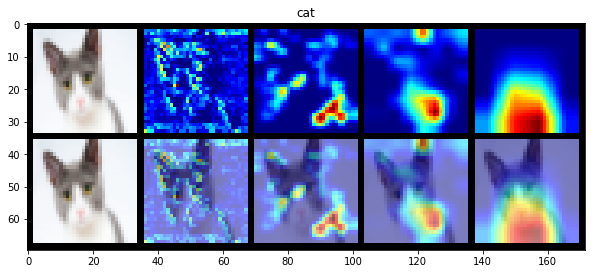

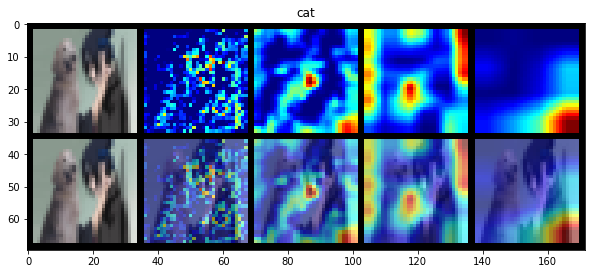

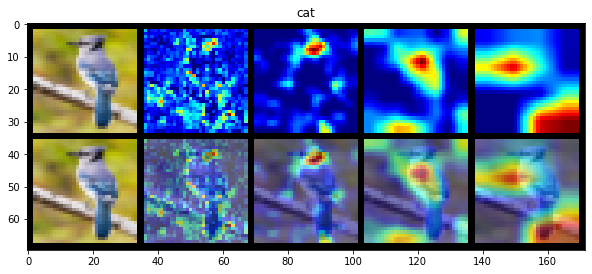

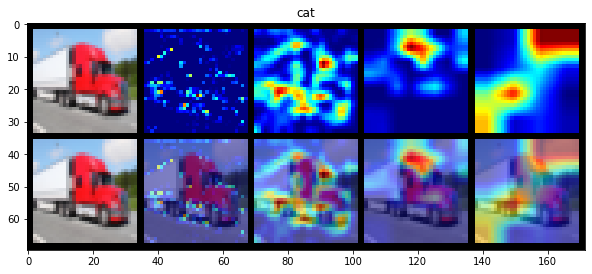

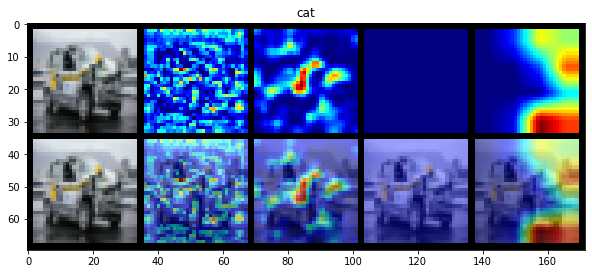

In [15]:
import copy
from torchvision.utils import make_grid, save_image
for i,k in enumerate(normed_torch_img):
  images1 = [torch_img_list[i].cpu()]
  images2 =  [torch_img_list[i].cpu()]
  b = copy.deepcopy(model.to(device))
  output = model(normed_torch_img[i])
  _, predicted = torch.max(output.data, 1)
  #print(classes[int(predicted)])
  layers =  [b.layer1,b.layer2,b.layer3,b.layer4]
  for j in layers:
    g = GradCAM(b,j)
    mask, _= g(normed_torch_img[i])
    heatmap, result = visualize_cam(mask,torch_img_list[i] )
    images1.extend([heatmap])
    images2.extend([result])
  grid_image = make_grid(images1+images2,nrow=5)
  imshow(grid_image,c = classes[int(predicted)])